In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")
sys.path.append(module_path+"/experiments")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites, Classifier
from utils import latent_transversal, load_checkpoint, save_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [4]:
whole_dataset = load_dsprites("../../datasets/dsprites.npz", False)
dataset = whole_dataset['imgs']
dataset = torch.from_numpy(dataset)

In [5]:
#np.random.seed(2)
#torch.manual_seed(2)
#random.seed(2)

In [6]:
def plot_all_transversals(model, original):
    fig = plt.figure(figsize=[12, 12])
    for i in range(10):
        imgs = latent_transversal(model, original, -3, 3, 10, i)
        for j, img in enumerate(imgs):
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.axis('off')
            plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
    plt.show()

In [7]:
def compute_latent_gaussian_variance(model, dataset, factorvae=False):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            if factorvae:
                _, _, logvar, _ = model(data.float())
            else:
                _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [8]:
def latent_transversal_used_latents(model, image, stds):
    ret = []
    for latent_index in range(10):
        if stds[latent_index] < 0.5:
            transversal = latent_transversal(model, image, -3, 3, 5, latent_index)
            ret.append([latent_index, stds[latent_index], transversal])
    return ret

In [69]:
def plot_recon(model, original, title, factorvae=False):
    if factorvae:
        recon, mu, logvar, _ = model(original)
    else:
        recon, mu, logvar = model(original)
    plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [32]:
def latent_transversal_plot(model, image, stds, title, wspace, hspace, figsize=(8,8),):
    transversals = latent_transversal_used_latents(model, image, stds)
    transversals.sort(key=lambda x: x[1])
    rows = ['z{0}, {1:.2}'.format(transversal[0], transversal[1]) for transversal in transversals]
    fig, axes = plt.subplots(nrows=len(transversals), ncols=5, figsize=figsize)

    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(torch.sigmoid(transversals[i][2][j].detach()).view(64,64), cmap='Greys_r')
            col.set_yticks([])
            col.set_xticks([])
    plt.tight_layout()
    
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, size='large')
    plt.suptitle(title, y=1.02)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
        

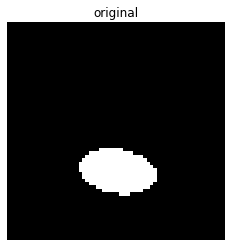

In [62]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.axis('off')
plt.title('original')
plt.show()

In [11]:
index

449051

# Beta-VAE with beta=1

In [12]:
model_beta1 = torch.load("../trained_models/betavae_beta1_e50_n.dat")
model_beta1.cpu()
model_beta1.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [13]:
# see Beta VAE notebook for computation
latent_gaussian_std_beta1 = [0.0514, 0.9818, 0.1145, 0.9793, 0.0236, 0.1030, 0.0533, 0.0572, 0.0401,
        0.9770]

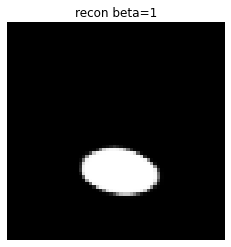

In [15]:
plot_recon(model_beta1, original, 'recon beta=1')

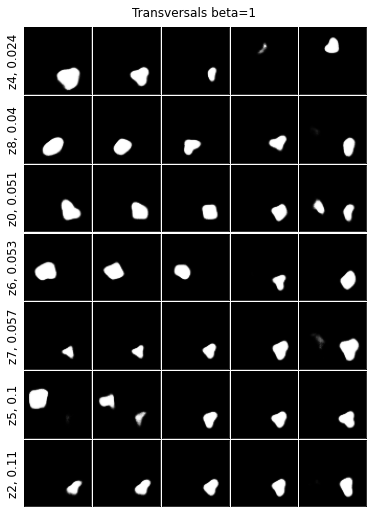

In [90]:
latent_transversal_plot(model_beta1, original, 
                        latent_gaussian_std_beta1, 
                        'Transversals beta=1', 
                        0.01, 0.03,
                        figsize=(5.1, 7))

# Beta-VAE with beta=4

In [63]:
model_beta4 = torch.load("../trained_models/betavae_beta4_e50_n.dat")
model_beta4.cpu()
model_beta4.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [63]:
#Computation takes a lot of time, please use the next cell to assign directly
latent_gaussian_std_beta4 = compute_latent_gaussian_variance(model_beta4, dataset).tolist()

...........

In [72]:
latent_gaussian_std_beta4

[0.9948016405105591,
 0.9936812520027161,
 0.9945016503334045,
 0.2888352572917938,
 0.9963180422782898,
 0.9922326803207397,
 0.11154257506132126,
 0.04041251540184021,
 0.06364276260137558,
 0.18593019247055054]

In [36]:
latent_gaussian_std_beta4 = [0.9948016405105591,
                             0.9936812520027161,
                             0.9945016503334045,
                             0.2888352572917938,
                             0.9963180422782898,
                             0.9922326803207397,
                             0.11154257506132126,
                             0.04041251540184021,
                             0.06364276260137558,
                             0.18593019247055054]

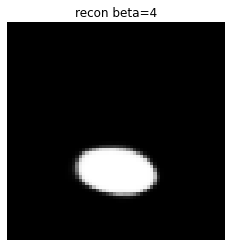

In [71]:
plot_recon(model_beta4, original, 'recon beta=4')

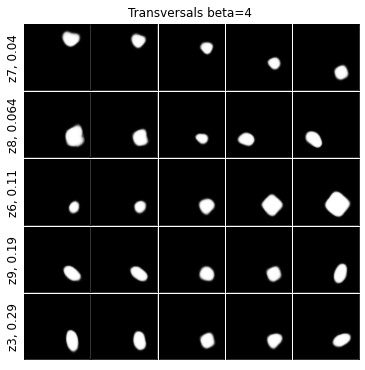

In [85]:
latent_transversal_plot(model_beta4, original, 
                        latent_gaussian_std_beta4, 
                        'Transversals beta=4', 
                        0.01, 0.03,
                        figsize=(5,5))

# Control-VAE with C=10

In [43]:
model_c10 = torch.load("../trained_models/controlvae_epoch50_lr1e2_Cmax10.dat")
model_c10.cpu()
model_c10.eval()

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [23]:
latent_gaussian_std_c10 = compute_latent_gaussian_variance(model, dataset).tolist()

...........

In [24]:
latent_gaussian_std_c10

[0.043746400624513626,
 0.3879627287387848,
 0.993424117565155,
 0.1351167857646942,
 0.9954754114151001,
 0.04095333069562912,
 0.9939906001091003,
 0.9952494502067566,
 0.9936495423316956,
 0.9938984513282776]

In [46]:
latent_gaussian_std_c10 = [0.043746400624513626,
                             0.3879627287387848,
                             0.993424117565155,
                             0.1351167857646942,
                             0.9954754114151001,
                             0.04095333069562912,
                             0.9939906001091003,
                             0.9952494502067566,
                             0.9936495423316956,
                             0.9938984513282776]

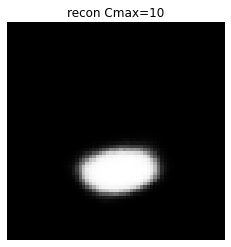

In [67]:
plot_recon(model_c10, original, 'recon Cmax=10')

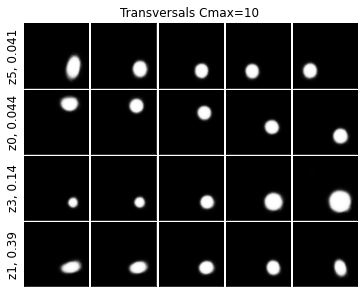

In [83]:
latent_transversal_plot(model_c10, original, latent_gaussian_std_c10, 
                        'Transversals Cmax=10', 
                        0.01, 0.03,
                        figsize=(5,4))

# Factor-VAE with gamma=5

In [55]:
model_gamma5 = torch.load("../trained_models/factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat")
model_gamma5.cpu()
model_gamma5.eval()

FactorVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [34]:
latent_gaussian_std_gamma5 = compute_latent_gaussian_variance(model, dataset, factorvae=True).tolist()

...........

In [35]:
latent_gaussian_std_gamma5

[0.11379950493574142,
 0.988315224647522,
 0.06986241042613983,
 0.018830878660082817,
 0.98553466796875,
 0.9848303198814392,
 0.9871156215667725,
 0.04981806129217148,
 0.02033691294491291,
 0.981386661529541]

In [54]:
latent_gaussian_std_gamma5 = [0.11379950493574142,
 0.988315224647522,
 0.06986241042613983,
 0.018830878660082817,
 0.98553466796875,
 0.9848303198814392,
 0.9871156215667725,
 0.04981806129217148,
 0.02033691294491291,
 0.981386661529541]

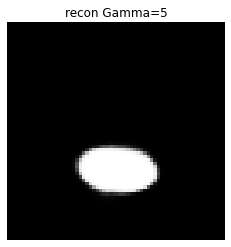

In [70]:
plot_recon(model_gamma5, original, 'recon Gamma=5', factorvae=True)

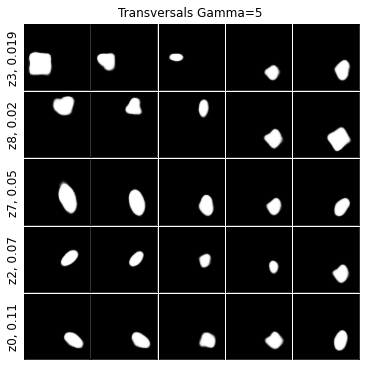

In [84]:
latent_transversal_plot(model_gamma5, original, latent_gaussian_std_gamma5, 
                        'Transversals Gamma=5', 
                        0.01, 0.03,
                        figsize=(5,5))

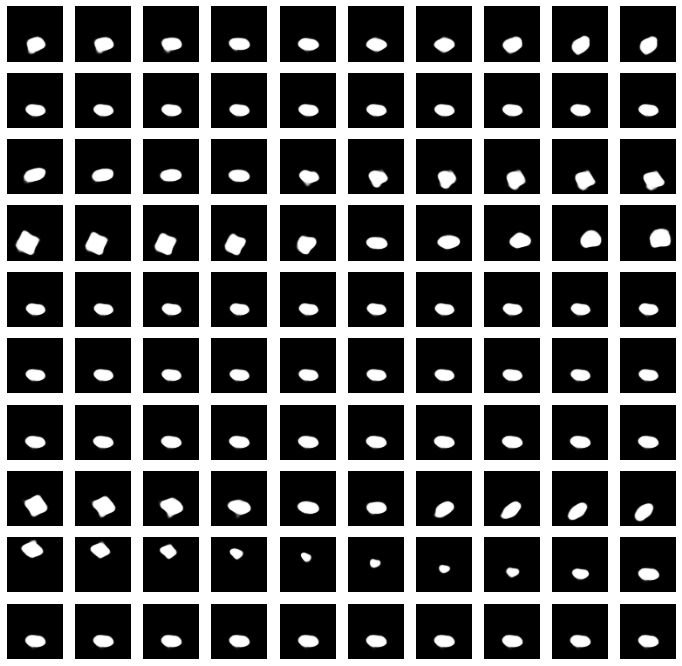

In [41]:
plot_all_transversals(model, original)

In [79]:
models = [
    model_beta1,
    model_beta4,
    model_c10,
    model_gamma5,
]
titles = [
    'beta1',
    'beta4',
    'c10',
    'gamma5'
]

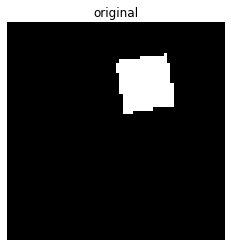

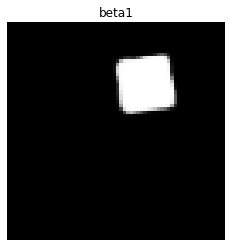

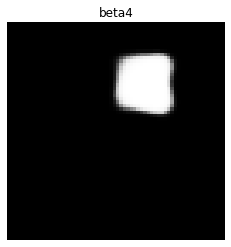

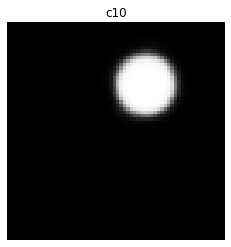

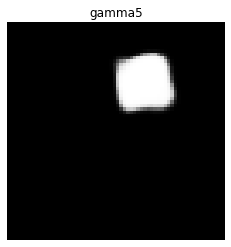

In [93]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.axis('off')
plt.title('original')
plt.show()

for i, model in enumerate(models):
    if i != 3:
        plot_recon(model, original, titles[i])
    else:
        plot_recon(model, original, titles[i], factorvae=True)